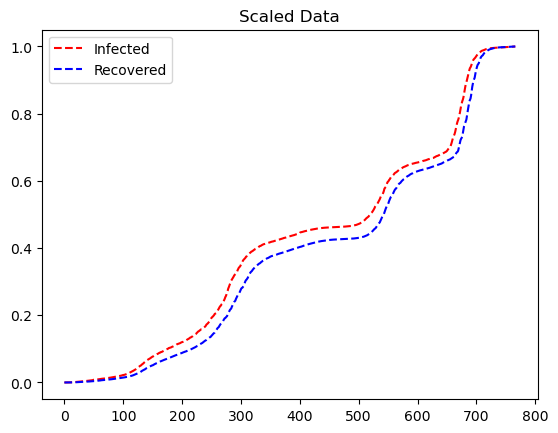

++++++++++++++++++Data Processing without MPI+++++++++++++++++++++++

CPU time for data preprocessing in seconds: 0.3260053059999999


In [4]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import process_time    #checking cpu time
from sklearn.preprocessing import MinMaxScaler   #for scaling data
#specify the scaling type
scaler =MinMaxScaler()
#get the start time
import sys
sys.path.insert(0, '../../Utilities/')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
c_dir =os.getcwd()
path = '/Figures/'   #for sir models
out = c_dir +path
if not os.path.exists(out):
    os.makedirs(out)

#load the data
data =pd.read_csv("tndata.csv")

#define the preprocess function
def data_process(data, scaler, cs ="yes"):
    #reverse index
    tdata=data.reindex(index=data.index[::-1])
    #get the infected 
    I=tdata['TOTAL_CONFIRMED']
    #get the recovered
    R =tdata['TOTAL_INACTIVE_RECOVERED']
    #get the length of the data
    nn =len(I)
    # show whether want to scaling
    if cs =="yes": ##indicate yes
        tt=np.linspace(0,nn, nn)
        y1 =np.array(I[:nn]).reshape((-1,1))
        y2 =np.array(R[:nn]).reshape((-1,1))
        #scaling
        II =scaler.fit_transform(y1)
        RR =scaler.fit_transform(y2)
        #plot
        plt.plot(tt, II, '--r')
        plt.plot(tt, RR, '--b')
        plt.legend(['Infected', 'Recovered'])
        plt.title('Scaled Data') 
        plt.show()
    else:  ##indicate no
        tt=np.linspace(0,nn, nn)
        II =np.array(I[:nn]).reshape((-1,1))
        RR =np.array(R[:nn]).reshape((-1,1))
        #plot
        plt.plot(tt, II, '--r')
        plt.plot(tt, RR, '--b')
        plt.legend(['Infected', 'Recovered'])
        plt.title('UnScaled Data') 
        plt.show()    
    return tt, II, RR
    
start =process_time()
tt, II, RR=data_process(data, scaler, "yes")  #scaled

stop = process_time()

print("++++++++++++++++++Data Processing without MPI+++++++++++++++++++++++\n")
print("CPU time for data preprocessing in seconds:",stop-start) 

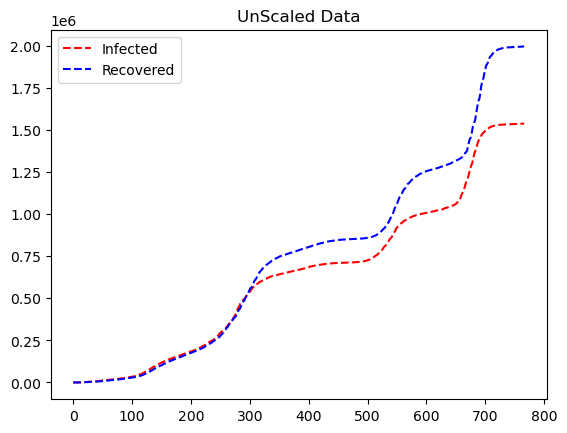

++++++++++++++++++Data Processing without MPI+++++++++++++++++++++++

CPU time for data preprocessing in seconds: 0.3317091940000001


In [5]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import process_time    #checking cpu time
from sklearn.preprocessing import MinMaxScaler   #for scaling data
#specify the scaling type
scaler =MinMaxScaler()
#get the start time
import sys
sys.path.insert(0, '../../Utilities/')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
c_dir =os.getcwd()
path = '/Figures/'   #for sir models
out = c_dir +path
if not os.path.exists(out):
    os.makedirs(out)

#load the data
data =pd.read_csv("tndata.csv")

#define the preprocess function
def data_process(data, scaler, cs ="yes"):
    #reverse index
    tdata=data.reindex(index=data.index[::-1])
    #get the infected 
    I=tdata['TOTAL_CONFIRMED']
    #get the recovered
    R =tdata['TOTAL_INACTIVE_RECOVERED']
    #get the length of the data
    nn =len(I)
    # show whether want to scaling
    if cs =="yes": ##indicate yes
        tt=np.linspace(0,nn, nn)
        y1 =np.array(I[:nn]).reshape((-1,1))
        y2 =np.array(R[:nn]).reshape((-1,1))
        #scaling
        II =scaler.fit_transform(y1)
        RR =scaler.fit_transform(y2)
        #plot
        plt.plot(tt, II, '--r')
        plt.plot(tt, RR, '--b')
        plt.legend(['Infected', 'Recovered'])
        plt.title('Scaled Data') 
        plt.show()
    else:  ##indicate no
        tt=np.linspace(0,nn, nn)
        II =np.array(I[:nn]).reshape((-1,1))
        RR =np.array(R[:nn]).reshape((-1,1))
        #plot
        plt.plot(tt, II, '--r')
        plt.plot(tt, RR, '--b')
        plt.legend(['Infected', 'Recovered'])
        plt.title('UnScaled Data') 
        plt.show()    
    return tt, II, RR
    
start =process_time()
tt, II, RR=data_process(data, scaler, "no")  #unscaled

stop = process_time()
print("++++++++++++++++++Data Processing without MPI+++++++++++++++++++++++\n")
print("CPU time for data preprocessing in seconds:",stop-start) 

In [6]:
%%file script.py
from mpi4py import MPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def load_data():
    # Load the data in the master process (rank 0)
    if rank == 0:
        return pd.read_csv("tndata.csv")
    else:
        return None

def broadcast_data(data):
    # Broadcast data to all processes
    return comm.bcast(data, root=0)

def preprocess_data(data, scaler, cs="yes"):
    # Reverse index
    tdata = data.reindex(index=data.index[::-1])

    # Get the infected and recovered data
    I = tdata['TOTAL_CONFIRMED']
    R = tdata['TOTAL_INACTIVE_RECOVERED']

    # Get the length of the data
    nn = len(I)

    # Show whether scaling is required
    if cs == "yes":
        tt = np.linspace(0, nn, nn)
        y1 = np.array(I[:nn]).reshape((-1, 1))
        y2 = np.array(R[:nn]).reshape((-1, 1))

        # Scaling
        II = scaler.fit_transform(y1)
        RR = scaler.fit_transform(y2)

        # Plot scaled data in the master process
        if rank == 0:
            plot_data(tt, II, RR)
    else:
        tt = np.linspace(0, nn, nn)
        II = np.array(I[:nn]).reshape((-1, 1))
        RR = np.array(R[:nn]).reshape((-1, 1))

        # Plot unscaled data in the master process
        if rank == 0:
            plot_data(tt, II, RR)

def plot_data(tt, II, RR):
    # Plotting function
    plt.plot(tt, II, '--r')
    plt.plot(tt, RR, '--b')
    plt.legend(['Infected', 'Recovered'])
    plt.title('Scaled Data' if cs == "yes" else 'Unscaled Data')
    plt.show()

comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
scaler = MinMaxScaler()

# Load and broadcast data
data = load_data()
data = broadcast_data(data)

# Define the preprocess function
cs = "yes"  # Set cs as needed
preprocess_data(data, scaler, cs)

if rank == 0:
    print("Rank 0 finished")

Overwriting script.py


In [7]:
from time import process_time
start =process_time()

!mpiexec  -np 4 python script.py

stop = process_time()

print("++++++++++++++++++Data Processing with MPI+++++++++++++++++++++++\n")
print("CPU time for data preprocessing in seconds:",stop-start) 

Figure(640x480)
Rank 0 finished
++++++++++++++++++Data Processing with MPI+++++++++++++++++++++++

CPU time for data preprocessing in seconds: 0.033826043999999555


In [8]:
%%file script1.py
from mpi4py import MPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def load_data():
    # Load the data in the master process (rank 0)
    if rank == 0:
        return pd.read_csv("tndata.csv")
    else:
        return None

def broadcast_data(data):
    # Broadcast data to all processes
    return comm.bcast(data, root=0)

def preprocess_data(data, scaler, cs="yes"):
    # Reverse index
    tdata = data.reindex(index=data.index[::-1])

    # Get the infected and recovered data
    I = tdata['TOTAL_CONFIRMED']
    R = tdata['TOTAL_INACTIVE_RECOVERED']

    # Get the length of the data
    nn = len(I)

    # Show whether scaling is required
    if cs == "yes":
        tt = np.linspace(0, nn, nn)
        y1 = np.array(I[:nn]).reshape((-1, 1))
        y2 = np.array(R[:nn]).reshape((-1, 1))

        # Scaling
        II = scaler.fit_transform(y1)
        RR = scaler.fit_transform(y2)

        # Plot scaled data in the master process
        if rank == 0:
            plot_data(tt, II, RR)
    else:
        tt = np.linspace(0, nn, nn)
        II = np.array(I[:nn]).reshape((-1, 1))
        RR = np.array(R[:nn]).reshape((-1, 1))

        # Plot unscaled data in the master process
        if rank == 0:
            plot_data(tt, II, RR)

def plot_data(tt, II, RR):
    # Plotting function
    plt.plot(tt, II, '--r')
    plt.plot(tt, RR, '--b')
    plt.legend(['Infected', 'Recovered'])
    plt.title('Scaled Data' if cs == "yes" else 'Unscaled Data')
    plt.show()

comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
scaler = MinMaxScaler()

# Load and broadcast data
data = load_data()
data = broadcast_data(data)

# Define the preprocess function
cs = "no"  # Set cs as needed
preprocess_data(data, scaler, cs)

if rank == 0:
    print("Rank 0 finished")

Overwriting script1.py


In [9]:
from time import process_time
start =process_time()

!mpiexec  -np 4 python script1.py

stop = process_time()

print("++++++++++++++++++Data Processing with MPI+++++++++++++++++++++++\n")
print("CPU time for data preprocessing in seconds:",stop-start) 

Figure(640x480)
Rank 0 finished
++++++++++++++++++Data Processing with MPI+++++++++++++++++++++++

CPU time for data preprocessing in seconds: 0.03262635000000014


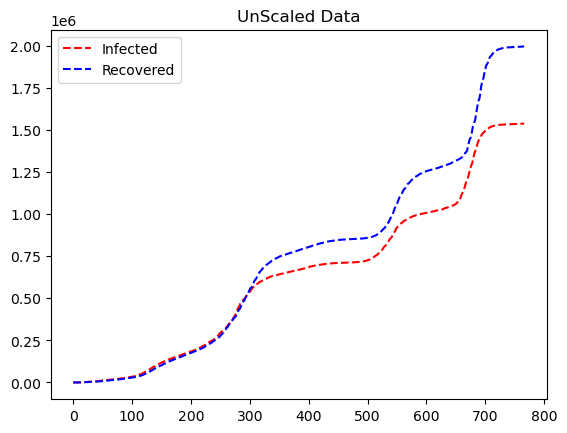

Tennessee outcomes on CPU............
LSTM Training


In [ ]:
from rnn_models_cpu import *
import torch
tt, II, RR =data_process(data,scaler, 'no')
#RNN models
start =process_time()
i_true_l, i_pred_l, _, _, _, _,_, i_loss_l=run_model_cpu(II, 'LSTM', 1500, 128, 500, 0.8) 
i_true_b, i_pred_b, _, _, _, _,_, i_loss_b=run_model_cpu(II, 'BiLSTM', 1500, 128, 500, 0.8)
i_true_g, i_pred_g, _, _, _, _,_, i_loss_g=run_model_cpu(II, 'GRU', 1500, 100, 500, 0.8)

x_t =np.arange(0, len(i_pred_l),1).reshape((-1,1))

plt.plot(x_t, i_true_l, '-o')
plt.plot(x_t, i_pred_l, '--b')
plt.plot(x_t, i_pred_b, '--r')
plt.plot(x_t, i_pred_g, '--c')
plt.legend(['LSTM', 'BiLSTM', 'GRU'])
plt.title('Modeling without mpi on CPU')
plt.savefig(out+'wompi_cpu.png')
plt.show()

stop = process_time()

print("++++++++++++++++++Modeling Infected Data without MPI on CPU+++++++++++++++++++++++\n")
print("Time for modeling without MPI on CPU in seconds:",stop-start) 

# Modeling with MPI on CPU

# When P=1

In [10]:
%%file script2.py
#!/usr/bin/env python
from mpi4py import MPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import process_time    #checking cpu time
from sklearn.preprocessing import MinMaxScaler 
import time
import sys
sys.path.insert(0, '../../Utilities/')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
c_dir =os.getcwd()
path = '/Figures/'   #for sir models
out = c_dir +path
if not os.path.exists(out):
    os.makedirs(out)
from rnn_models_cpu import *
#load the data
data =pd.read_csv("tndata.csv")
# tt, II, RR =data_process(data,scaler, 'no')
scaler =MinMaxScaler()

#define the preprocess function
def data_process(data, scaler, cs ="yes"):
    #reverse index
    tdata=data.reindex(index=data.index[::-1])
    #get the infected 
    I=tdata['TOTAL_CONFIRMED']
    #get the recovered
    R =tdata['TOTAL_INACTIVE_RECOVERED']
    #get the length of the data
    nn =len(I)
    # show whether want to scaling
    if cs =="yes": ##indicate yes
        tt=np.linspace(0,nn, nn)
        y1 =np.array(I[:nn]).reshape((-1,1))
        y2 =np.array(R[:nn]).reshape((-1,1))
        #scaling
        II =scaler.fit_transform(y1)
        RR =scaler.fit_transform(y2)
        #plot
        plt.plot(tt, II, '--r')
        plt.plot(tt, RR, '--b')
        plt.legend(['Infected', 'Recovered'])
        plt.title('Scaled Data') 
        plt.show()
    else:  ##indicate no
        tt=np.linspace(0,nn, nn)
        II =np.array(I[:nn]).reshape((-1,1))
        RR =np.array(R[:nn]).reshape((-1,1))
        #plot
        plt.plot(tt, II, '--r')
        plt.plot(tt, RR, '--b')
        plt.legend(['Infected', 'Recovered'])
        plt.title('UnScaled Data') 
        plt.show()    
    return tt, II, RR
p=1

comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
name = MPI.Get_processor_name()
if rank == 0:
    tt, II, RR = data_process(data,scaler, 'no')
    i_true_l, i_pred_l, _, _, _, _,ep, i_loss_l=run_model_cpu(II, 'LSTM', 1500, 128, 500, 0.8) 
    i_true_b, i_pred_b, _, _, _, _,_, i_loss_b=run_model_cpu(II, 'BiLSTM', 1500, 128, 500, 0.8)
    i_true_g, i_pred_g, _, _, _, _,_, i_loss_g=run_model_cpu(II, 'GRU', 1500, 100, 500, 0.8)
    x_t =np.arange(0, len(i_pred_l),1).reshape((-1,1))
    
    
    plt.plot(x_t, i_true_l, '-o')
    plt.plot(x_t, i_pred_l, '--b')
    plt.plot(x_t, i_pred_b, '--r')
    plt.plot(x_t, i_pred_g, '--c')
    plt.legend(['LSTM', 'BiLSTM', 'GRU'])
    plt.title('Modeling with MPI on CPU')
    plt.savefig(out+'wmpi_cpu_{}.png'.format(p))
    plt.show()
    print("rank0 finished")

Overwriting script2.py


In [11]:
start =process_time()

!mpiexec  -np 1 python script2.py

stop = process_time()

print("++++++++++++++++++Modeling with MPI on CPU+++++++++++++++++++++++\n")
print("Tme for modeling of Infected Data on CPU in seconds:",stop-start) 

Figure(640x480)
Tennessee outcomes on CPU............
LSTM Training
Epoch 100/1500, Total Loss: 3.137e-03, Time:0.13 seconds
Epoch 200/1500, Total Loss: 3.550e-04, Time:0.13 seconds
Epoch 300/1500, Total Loss: 2.511e-04, Time:0.13 seconds
Epoch 400/1500, Total Loss: 1.964e-04, Time:0.13 seconds
Epoch 500/1500, Total Loss: 1.165e-04, Time:0.14 seconds
Epoch 600/1500, Total Loss: 1.012e-04, Time:0.14 seconds
Epoch 700/1500, Total Loss: 1.685e-04, Time:0.14 seconds
Epoch 800/1500, Total Loss: 9.668e-05, Time:0.13 seconds
Epoch 900/1500, Total Loss: 6.711e-05, Time:0.14 seconds
Epoch 1000/1500, Total Loss: 5.258e-05, Time:0.13 seconds
Epoch 1100/1500, Total Loss: 8.715e-05, Time:0.13 seconds
Epoch 1200/1500, Total Loss: 7.023e-05, Time:0.14 seconds
Epoch 1300/1500, Total Loss: 4.362e-05, Time:0.14 seconds
Epoch 1400/1500, Total Loss: 3.843e-05, Time:0.13 seconds
Epoch 1500/1500, Total Loss: 5.759e-05, Time:0.13 seconds
LSTM Total Training Time in seconds 200.52133345603943
Evaluation Time:

# When p=2

In [12]:
%%file script3.py
#!/usr/bin/env python
from mpi4py import MPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import process_time    #checking cpu time
from sklearn.preprocessing import MinMaxScaler 
import time
import sys
sys.path.insert(0, '../../Utilities/')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
c_dir =os.getcwd()
path = '/Figures/'   #for sir models
out = c_dir +path
if not os.path.exists(out):
    os.makedirs(out)
from rnn_models_cpu import *
#load the data
data =pd.read_csv("tndata.csv")
# tt, II, RR =data_process(data,scaler, 'no')
scaler =MinMaxScaler()

#define the preprocess function
def data_process(data, scaler, cs ="yes"):
    #reverse index
    tdata=data.reindex(index=data.index[::-1])
    #get the infected 
    I=tdata['TOTAL_CONFIRMED']
    #get the recovered
    R =tdata['TOTAL_INACTIVE_RECOVERED']
    #get the length of the data
    nn =len(I)
    # show whether want to scaling
    if cs =="yes": ##indicate yes
        tt=np.linspace(0,nn, nn)
        y1 =np.array(I[:nn]).reshape((-1,1))
        y2 =np.array(R[:nn]).reshape((-1,1))
        #scaling
        II =scaler.fit_transform(y1)
        RR =scaler.fit_transform(y2)
        #plot
        plt.plot(tt, II, '--r')
        plt.plot(tt, RR, '--b')
        plt.legend(['Infected', 'Recovered'])
        plt.title('Scaled Data') 
        plt.show()
    else:  ##indicate no
        tt=np.linspace(0,nn, nn)
        II =np.array(I[:nn]).reshape((-1,1))
        RR =np.array(R[:nn]).reshape((-1,1))
        #plot
        plt.plot(tt, II, '--r')
        plt.plot(tt, RR, '--b')
        plt.legend(['Infected', 'Recovered'])
        plt.title('UnScaled Data') 
        plt.show()    
    return tt, II, RR
p=2

comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
name = MPI.Get_processor_name()
if rank == 0:
    tt, II, RR =data_process(data,scaler, 'no')
    i_true_l, i_pred_l, _, _, _, _,ep, i_loss_l=run_model_cpu(II, 'LSTM', 1500, 128, 500, 0.8) 
    i_true_b, i_pred_b, _, _, _, _,_, i_loss_b=run_model_cpu(II, 'BiLSTM', 1500, 128, 500, 0.8)
    i_true_g, i_pred_g, _, _, _, _,_, i_loss_g=run_model_cpu(II, 'GRU', 1500, 100, 500, 0.8)
    x_t =np.arange(0, len(i_pred_l),1).reshape((-1,1))
    
    
    plt.plot(x_t, i_true_l, '-o')
    plt.plot(x_t, i_pred_l, '--b')
    plt.plot(x_t, i_pred_b, '--r')
    plt.plot(x_t, i_pred_g, '--c')
    plt.legend(['LSTM', 'BiLSTM', 'GRU'])
    plt.title('Modeling with MPI on CPU')
    plt.savefig(out+'wmpi_cpu_{}.png'.format(p))
    plt.show()
    print("rank0 finished")

Overwriting script3.py


In [13]:
start =process_time()

!mpiexec  -np 2 python script3.py

stop = process_time()

print("++++++++++++++++++Modeling with MPI on CPU+++++++++++++++++++++++\n")
print("Tme for modeling of Infected Data on CPU in seconds:",stop-start)

Figure(640x480)
Tennessee outcomes on CPU............
LSTM Training
Epoch 100/1500, Total Loss: 3.137e-03, Time:0.13 seconds
Epoch 200/1500, Total Loss: 3.550e-04, Time:0.13 seconds
Epoch 300/1500, Total Loss: 2.511e-04, Time:0.14 seconds
Epoch 400/1500, Total Loss: 1.964e-04, Time:0.13 seconds
Epoch 500/1500, Total Loss: 1.165e-04, Time:0.13 seconds
Epoch 600/1500, Total Loss: 1.012e-04, Time:0.13 seconds
Epoch 700/1500, Total Loss: 1.685e-04, Time:0.13 seconds
Epoch 800/1500, Total Loss: 9.668e-05, Time:0.13 seconds
Epoch 900/1500, Total Loss: 6.711e-05, Time:0.13 seconds
Epoch 1000/1500, Total Loss: 5.258e-05, Time:0.13 seconds
Epoch 1100/1500, Total Loss: 8.715e-05, Time:0.14 seconds
Epoch 1200/1500, Total Loss: 7.023e-05, Time:0.13 seconds
Epoch 1300/1500, Total Loss: 4.362e-05, Time:0.14 seconds
Epoch 1400/1500, Total Loss: 3.843e-05, Time:0.13 seconds
Epoch 1500/1500, Total Loss: 5.759e-05, Time:0.13 seconds
LSTM Total Training Time in seconds 200.49431490898132
Evaluation Time: